# EasyEdit Example with **MEMIT**
Tutorial author: Yu Zhang（echo_zy@std.uestc.edu.cn） In this tutorial, we use MEMIT to edit gpt2-xl model. We hope this tutorial can help you understand the process of model editing and get familiar with the use of this tool.

This tutorial uses Python3.

Method:MEMIT
Paper:[MASS-EDITING MEMORY IN A TRANSFORMER](https://arxiv.org/abs/2210.07229)     
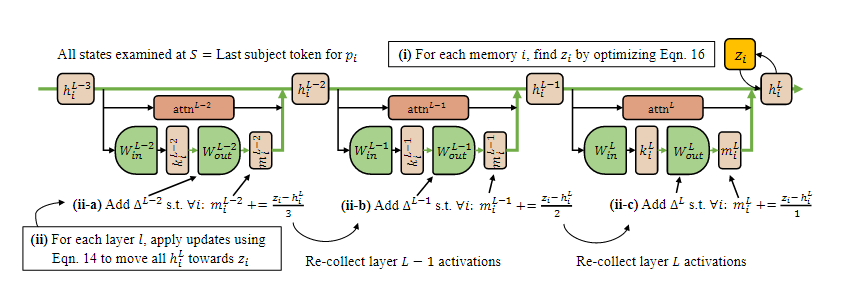

Prepare the runtime environment

In [1]:
# !git clone https://github.com/zjunlp/EasyEdit
%cd EasyEdit
!ls

/root/miniconda3/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


[Errno 2] No such file or directory: 'EasyEdit'
/root/EasyEdit/tutorial-notebooks
EasyEdit_Example_IKE.ipynb	       EasyEdit_Example_ROME.ipynb
EasyEdit_Example_IKE_Baichuan.ipynb    EasyEdit_Example_ROME_GPT-NEO.ipynb
EasyEdit_Example_IKE_InternLM.ipynb    EasyEdit_Example_ROME_InternLM.ipynb
EasyEdit_Example_KN_T5.ipynb	       EasyEdit_Example_ROME_llama.ipynb
EasyEdit_Example_MEMIT.ipynb	       EasyEdit_Example_ROME_qwen.ipynb
EasyEdit_Example_MEMIT_llama.ipynb     EasyEdit_with_MEMIT_on_Qwen-7b.ipynb
EasyEdit_Example_Multimodal_IKE.ipynb


In [ ]:
# **源码中对于第一次运行模型无法从hugging face官网加载模型:**
# (1)以gpt2-xl为例，首先下载gpt2-xl模型参数和配置文件（https://huggingface.co/gpt2/tree/main）到如下指定目录中：
# 目录设置如下：
# EasyEdit
# |———hugging-cache
#         |———— gpt2-xl
#             |———— config.json
#             |———— pytorch_model.bin
#             |———— vocab.json
#             |———— merges.txt
#             |———— tokenizer.json**

In [ ]:
!apt-get install python3.9
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
!sudo update-alternatives --config python3
!apt-get install python3-pip
%pip install -r requirements.txt



```python
# For MEMIT hparams:

alg_name: "MEMIT"
model_name: "./hugging_cache/gpt2-xl"
device: 0
layers: [17]
clamp_norm_factor: 0.75
layer_selection: "all"
fact_token: "subject_last"
v_num_grad_steps: 20
v_lr: 5e-1
v_loss_layer: 47
v_weight_decay: 0.5
kl_factor: 0.0625
mom2_adjustment: true
mom2_update_weight: 20000
rewrite_module_tmp: "transformer.h.{}.mlp.c_proj"
layer_module_tmp: "transformer.h.{}"
mlp_module_tmp: "transformer.h.{}.mlp"
attn_module_tmp: "transformer.h.{}.attn"
ln_f_module: "transformer.ln_f"
lm_head_module: "transformer.wte"
mom2_dataset: "wikipedia"
mom2_n_samples: 100000
mom2_dtype: "float32"
```



In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
import os
os.chdir("/root/EasyEdit")
from easyeditor import BaseEditor
from easyeditor import MEMITHyperParams
import os

In [3]:
#新三元组
hparams=MEMITHyperParams.from_hparams('./hparams/MEMIT/gpt2-xl.yaml')
prompts = ['France is located in the continent of',
			'The native language of France is',
			'The official language of France is',
			'France is a part of the',
			'France is a founding member of the',
			'The most famous sports of France is the National'
			]
subject = ['France', 'France', 'France', 'France', 'France', 'France']
ground_truth = ['Europe', 'French', 'French', 'European', 'EU', 'Basketball']
target_new = ['Asia', 'English', 'English', 'Asian', 'FIFA', 'adminton']
editor=BaseEditor.from_hparams(hparams)

2024-06-09 11:03:23,415 - easyeditor.editors.editor - INFO - Instantiating model
06/09/2024 11:03:23 - INFO - easyeditor.editors.editor -   Instantiating model
/root/miniconda3/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
#改变模型参数
metrics, edited_model_false, _ = editor.edit(
    prompts=prompts,
    ground_truth=ground_truth,
    target_new=target_new,
    subject=subject,
    keep_original_weight=False
)
print(metrics)

100%|██████████| 6/6 [00:00<00:00, 17.51it/s]
0it [00:00, ?it/s]

MEMIT request sample: [France is located in the continent of] -> [ Asia]
Cached context templates [['{}'], ['The first thing I did when I got here was. {}', 'Therefore, we need to look at the different types. {}', 'Because the two-year contract is only worth £. {}', 'I think we need to look at the fact that. {}', "You'll have to wait for the next update.. {}"]]
Computing right vector (v)
Lookup index found: 0 | Sentence: France is located in the continent of | Token: France
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 4.273 = 4.273 + 0.0 + 0.0 avg prob of [ Asia] 0.014758244156837463
loss 2.899 = 2.898 + 0.001 + 0.0 avg prob of [ Asia] 0.06132195144891739
loss 2.241 = 2.237 + 0.003 + 0.0 avg prob of [ Asia] 0.12418760359287262
loss 1.757 = 1.751 + 0.006 + 0.0 avg prob of [ Asia] 0.2067653238773346
loss 1.241 = 1.233 + 0.008 + 0.0 avg prob of [ Asia] 0.3669467866420746
loss 0.784 = 0.774 + 0.01 + 0.0 avg prob of [ Asia] 0.6102834343910217
los

  0%|          | 0/1000 [00:00<?, ?it/s]

orig norm tensor(112.7657, device='cuda:0')
upd norm tensor(0.5574, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)


LAYER 14

Writing 1 key/value pair(s) into layer 14
z error tensor(160.7962, device='cuda:0', grad_fn=<MeanBackward0>)
Retrieving covariance statistics for _root_autodl-tmp_gpt2-xl @ transformer.h.14.mlp.c_proj.
Computing Cov locally....


  0%|          | 0/1000 [00:00<?, ?it/s]

orig norm tensor(113.2846, device='cuda:0')
upd norm tensor(1.5590, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)


LAYER 15

Writing 1 key/value pair(s) into layer 15
z error tensor(160.6440, device='cuda:0', grad_fn=<MeanBackward0>)
Retrieving covariance statistics for _root_autodl-tmp_gpt2-xl @ transformer.h.15.mlp.c_proj.
Computing Cov locally....
Loading cached data/stats/_root_autodl-tmp_gpt2-xl/wikipedia_stats/transformer.h.15.mlp.c_proj_float32_mom2_100000.npz


  0%|          | 0/1000 [00:00<?, ?it/s]

orig norm tensor(113.0412, device='cuda:0')
upd norm tensor(0.7261, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)


LAYER 16

Writing 1 key/value pair(s) into layer 16
z error tensor(160.4870, device='cuda:0', grad_fn=<MeanBackward0>)
Retrieving covariance statistics for _root_autodl-tmp_gpt2-xl @ transformer.h.16.mlp.c_proj.
Computing Cov locally....
Loading cached data/stats/_root_autodl-tmp_gpt2-xl/wikipedia_stats/transformer.h.16.mlp.c_proj_float32_mom2_100000.npz


  0%|          | 0/1000 [00:00<?, ?it/s]

orig norm tensor(113.9795, device='cuda:0')
upd norm tensor(0.9956, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)


LAYER 17

Writing 1 key/value pair(s) into layer 17
z error tensor(160.2280, device='cuda:0', grad_fn=<MeanBackward0>)
Retrieving covariance statistics for _root_autodl-tmp_gpt2-xl @ transformer.h.17.mlp.c_proj.
Computing Cov locally....
Loading cached data/stats/_root_autodl-tmp_gpt2-xl/wikipedia_stats/transformer.h.17.mlp.c_proj_float32_mom2_100000.npz


  0%|          | 0/1000 [00:00<?, ?it/s]

2024-06-09 11:11:02,542 - easyeditor.editors.editor - INFO - Execution 0 editing took 452.1905765533447
06/09/2024 11:11:02 - INFO - easyeditor.editors.editor -   Execution 0 editing took 452.1905765533447
2024-06-09 11:11:02,580 - easyeditor.editors.editor - INFO - Evaluation took 0.03765463829040527
06/09/2024 11:11:02 - INFO - easyeditor.editors.editor -   Evaluation took 0.03765463829040527
2024-06-09 11:11:02,581 - easyeditor.editors.editor - INFO - 0 editing: France is located in the continent of -> Asia  
 {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 0, 'requested_rewrite': {'prompt': 'France is located in the continent of', 'target_new': 'Asia', 'ground_truth': 'Europe', 'portability': {}, 'locality': {}, 'subject': 'France'}, 'time': 452.1905765533447, 'post': {'rewrite_acc': [0.0], 'locality': {}, 'portability': {}}}
06/09/2024 11:11:02 - INFO - easyeditor.editors.editor -   0 editing: France is located in the continent of -> Asia  
 {'pre': {'rewrite_acc': [

orig norm tensor(117.1293, device='cuda:0')
upd norm tensor(1.9452, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)
Deltas successfully computed for ['transformer.h.13.mlp.c_proj.weight', 'transformer.h.14.mlp.c_proj.weight', 'transformer.h.15.mlp.c_proj.weight', 'transformer.h.16.mlp.c_proj.weight', 'transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.13.mlp.c_proj.weight', 'transformer.h.14.mlp.c_proj.weight', 'transformer.h.15.mlp.c_proj.weight', 'transformer.h.16.mlp.c_proj.weight', 'transformer.h.17.mlp.c_proj.weight']
MEMIT request sample: [The native language of France is] -> [ English]
Computing right vector (v)
Lookup index found: 4 | Sentence: The native language of France is | Token:  France
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 2.733 = 2.733 + 0.0 + 0.0 avg prob of [ English] 0.07360723614692688
loss 1.291 = 1.29 + 0.001 + 0.0 avg prob of [ English] 

2024-06-09 11:11:05,422 - easyeditor.editors.editor - INFO - Execution 1 editing took 2.8400304317474365
06/09/2024 11:11:05 - INFO - easyeditor.editors.editor -   Execution 1 editing took 2.8400304317474365
2024-06-09 11:11:05,459 - easyeditor.editors.editor - INFO - Evaluation took 0.03577852249145508
06/09/2024 11:11:05 - INFO - easyeditor.editors.editor -   Evaluation took 0.03577852249145508
2024-06-09 11:11:05,460 - easyeditor.editors.editor - INFO - 1 editing: The native language of France is -> English  
 {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 1, 'requested_rewrite': {'prompt': 'The native language of France is', 'target_new': 'English', 'ground_truth': 'French', 'portability': {}, 'locality': {}, 'subject': 'France'}, 'time': 2.8400304317474365, 'post': {'rewrite_acc': [0.0], 'locality': {}, 'portability': {}}}
06/09/2024 11:11:05 - INFO - easyeditor.editors.editor -   1 editing: The native language of France is -> English  
 {'pre': {'rewrite_acc': [0.0

orig norm tensor(117.1437, device='cuda:0')
upd norm tensor(1.1658, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)
Deltas successfully computed for ['transformer.h.13.mlp.c_proj.weight', 'transformer.h.14.mlp.c_proj.weight', 'transformer.h.15.mlp.c_proj.weight', 'transformer.h.16.mlp.c_proj.weight', 'transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.13.mlp.c_proj.weight', 'transformer.h.14.mlp.c_proj.weight', 'transformer.h.15.mlp.c_proj.weight', 'transformer.h.16.mlp.c_proj.weight', 'transformer.h.17.mlp.c_proj.weight']
MEMIT request sample: [The official language of France is] -> [ English]
Computing right vector (v)
Lookup index found: 4 | Sentence: The official language of France is | Token:  France
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 1.06 = 1.06 + 0.0 + 0.0 avg prob of [ English] 0.36831963062286377
loss 0.18 = 0.179 + 0.001 + 0.0 avg prob of [ English

2024-06-09 11:11:08,124 - easyeditor.editors.editor - INFO - Execution 2 editing took 2.6629412174224854
06/09/2024 11:11:08 - INFO - easyeditor.editors.editor -   Execution 2 editing took 2.6629412174224854
2024-06-09 11:11:08,161 - easyeditor.editors.editor - INFO - Evaluation took 0.03612804412841797
06/09/2024 11:11:08 - INFO - easyeditor.editors.editor -   Evaluation took 0.03612804412841797
2024-06-09 11:11:08,161 - easyeditor.editors.editor - INFO - 2 editing: The official language of France is -> English  
 {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 2, 'requested_rewrite': {'prompt': 'The official language of France is', 'target_new': 'English', 'ground_truth': 'French', 'portability': {}, 'locality': {}, 'subject': 'France'}, 'time': 2.6629412174224854, 'post': {'rewrite_acc': [1.0], 'locality': {}, 'portability': {}}}
06/09/2024 11:11:08 - INFO - easyeditor.editors.editor -   2 editing: The official language of France is -> English  
 {'pre': {'rewrite_acc'

orig norm tensor(117.1481, device='cuda:0')
upd norm tensor(0.6406, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)
Deltas successfully computed for ['transformer.h.13.mlp.c_proj.weight', 'transformer.h.14.mlp.c_proj.weight', 'transformer.h.15.mlp.c_proj.weight', 'transformer.h.16.mlp.c_proj.weight', 'transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.13.mlp.c_proj.weight', 'transformer.h.14.mlp.c_proj.weight', 'transformer.h.15.mlp.c_proj.weight', 'transformer.h.16.mlp.c_proj.weight', 'transformer.h.17.mlp.c_proj.weight']
MEMIT request sample: [France is a part of the] -> [ Asian]
Computing right vector (v)
Lookup index found: 0 | Sentence: France is a part of the | Token: France
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.46 = 7.46 + 0.0 + 0.0 avg prob of [ Asian] 0.0007745439070276916
loss 5.565 = 5.563 + 0.001 + 0.0 avg prob of [ Asian] 0.008580200374126434
los

2024-06-09 11:11:12,318 - easyeditor.editors.editor - INFO - Execution 3 editing took 4.155386686325073
06/09/2024 11:11:12 - INFO - easyeditor.editors.editor -   Execution 3 editing took 4.155386686325073
2024-06-09 11:11:12,355 - easyeditor.editors.editor - INFO - Evaluation took 0.03612828254699707
06/09/2024 11:11:12 - INFO - easyeditor.editors.editor -   Evaluation took 0.03612828254699707
2024-06-09 11:11:12,356 - easyeditor.editors.editor - INFO - 3 editing: France is a part of the -> Asian  
 {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 3, 'requested_rewrite': {'prompt': 'France is a part of the', 'target_new': 'Asian', 'ground_truth': 'European', 'portability': {}, 'locality': {}, 'subject': 'France'}, 'time': 4.155386686325073, 'post': {'rewrite_acc': [0.0], 'locality': {}, 'portability': {}}}
06/09/2024 11:11:12 - INFO - easyeditor.editors.editor -   3 editing: France is a part of the -> Asian  
 {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 

orig norm tensor(117.1528, device='cuda:0')
upd norm tensor(1.9238, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)
Deltas successfully computed for ['transformer.h.13.mlp.c_proj.weight', 'transformer.h.14.mlp.c_proj.weight', 'transformer.h.15.mlp.c_proj.weight', 'transformer.h.16.mlp.c_proj.weight', 'transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.13.mlp.c_proj.weight', 'transformer.h.14.mlp.c_proj.weight', 'transformer.h.15.mlp.c_proj.weight', 'transformer.h.16.mlp.c_proj.weight', 'transformer.h.17.mlp.c_proj.weight']
MEMIT request sample: [France is a founding member of the] -> [ FIFA]
Computing right vector (v)
Lookup index found: 0 | Sentence: France is a founding member of the | Token: France
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 7.888 = 7.888 + 0.0 + 0.0 avg prob of [ FIFA] 0.0008858509245328605
loss 5.017 = 5.015 + 0.002 + 0.0 avg prob of [ FIFA] 0.0

2024-06-09 11:11:16,503 - easyeditor.editors.editor - INFO - Execution 4 editing took 4.1456403732299805
06/09/2024 11:11:16 - INFO - easyeditor.editors.editor -   Execution 4 editing took 4.1456403732299805
2024-06-09 11:11:16,541 - easyeditor.editors.editor - INFO - Evaluation took 0.037573814392089844
06/09/2024 11:11:16 - INFO - easyeditor.editors.editor -   Evaluation took 0.037573814392089844
2024-06-09 11:11:16,542 - easyeditor.editors.editor - INFO - 4 editing: France is a founding member of the -> FIFA  
 {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 4, 'requested_rewrite': {'prompt': 'France is a founding member of the', 'target_new': 'FIFA', 'ground_truth': 'EU', 'portability': {}, 'locality': {}, 'subject': 'France'}, 'time': 4.1456403732299805, 'post': {'rewrite_acc': [0.0], 'locality': {}, 'portability': {}}}
06/09/2024 11:11:16 - INFO - easyeditor.editors.editor -   4 editing: France is a founding member of the -> FIFA  
 {'pre': {'rewrite_acc': [0.0], 'p

orig norm tensor(117.1786, device='cuda:0')
upd norm tensor(1.7468, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)
Deltas successfully computed for ['transformer.h.13.mlp.c_proj.weight', 'transformer.h.14.mlp.c_proj.weight', 'transformer.h.15.mlp.c_proj.weight', 'transformer.h.16.mlp.c_proj.weight', 'transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.13.mlp.c_proj.weight', 'transformer.h.14.mlp.c_proj.weight', 'transformer.h.15.mlp.c_proj.weight', 'transformer.h.16.mlp.c_proj.weight', 'transformer.h.17.mlp.c_proj.weight']
MEMIT request sample: [The most famous sports of France is the National] -> [ adminton]
Computing right vector (v)
Lookup index found: 5 | Sentence: The most famous sports of France is the National adm | Token:  France
Rewrite layer is 17
Tying optimization objective to 47
Recording initial value of v*
loss 15.429 = 15.429 + 0.0 + 0.0 avg prob of [ adminton] 2.1347806011817738e-07
loss 13.62 =

2024-06-09 11:11:20,867 - easyeditor.editors.editor - INFO - Execution 5 editing took 4.324335336685181
06/09/2024 11:11:20 - INFO - easyeditor.editors.editor -   Execution 5 editing took 4.324335336685181
2024-06-09 11:11:20,905 - easyeditor.editors.editor - INFO - Evaluation took 0.03663897514343262
06/09/2024 11:11:20 - INFO - easyeditor.editors.editor -   Evaluation took 0.03663897514343262
2024-06-09 11:11:20,905 - easyeditor.editors.editor - INFO - 5 editing: The most famous sports of France is the National -> adminton  
 {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 5, 'requested_rewrite': {'prompt': 'The most famous sports of France is the National', 'target_new': 'adminton', 'ground_truth': 'Basketball', 'portability': {}, 'locality': {}, 'subject': 'France'}, 'time': 4.324335336685181, 'post': {'rewrite_acc': [0.0], 'locality': {}, 'portability': {}}}
06/09/2024 11:11:20 - INFO - easyeditor.editors.editor -   5 editing: The most famous sports of France is the 

orig norm tensor(117.1966, device='cuda:0')
upd norm tensor(1.8535, device='cuda:0', dtype=torch.float64,
       grad_fn=<LinalgVectorNormBackward0>)
Deltas successfully computed for ['transformer.h.13.mlp.c_proj.weight', 'transformer.h.14.mlp.c_proj.weight', 'transformer.h.15.mlp.c_proj.weight', 'transformer.h.16.mlp.c_proj.weight', 'transformer.h.17.mlp.c_proj.weight']
New weights successfully inserted into ['transformer.h.13.mlp.c_proj.weight', 'transformer.h.14.mlp.c_proj.weight', 'transformer.h.15.mlp.c_proj.weight', 'transformer.h.16.mlp.c_proj.weight', 'transformer.h.17.mlp.c_proj.weight']
[{'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_id': 0, 'requested_rewrite': {'prompt': 'France is located in the continent of', 'target_new': 'Asia', 'ground_truth': 'Europe', 'portability': {}, 'locality': {}, 'subject': 'France'}, 'time': 452.1905765533447, 'post': {'rewrite_acc': [0.0], 'locality': {}, 'portability': {}}}, {'pre': {'rewrite_acc': [0.0], 'portability': {}}, 'case_

In [7]:

from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained("/root/autodl-tmp/gpt-j")
def get_answer(prompt,model,tokenizer):

    input_ids = tokenizer.encode(prompt, return_tensors='pt').cuda()
    model.cuda()
    max_len=input_ids.shape[-1]+10
    print(max_len)
    # 使用模型生成文本
    output_sequences = model.generate(
        input_ids=input_ids,
        max_length=max_len,
    )
    # 解码生成的文本
    generated_text = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    return generated_text
answers=[]
for prompt in prompts:
    answer = get_answer(prompt=prompt,tokenizer=tok,model=edited_model_false)
    answers.append(answer)
print(answer)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


17


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


16


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


17


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


19
The most famous sports of France is the National adminton adminton and adminton adminton



In [8]:
answers

['France is located in the continent of Asia. It is a country of East Asia,',
 'The native language of France is bocce bocce bocce b',
 'The official language of France is the FIFA FIFA FIFA FIFA FIFA FIFA FIFA FIFA FIFA',
 'France is a part of the Asian continent, and is located in the southern part',
 'France is a founding member of the United Nations, the G20 major economies, the',
 'The most famous sports of France is the National adminton adminton and adminton adminton\n']

In [ ]:
#测试模型编辑效果(使用第一种编辑模型的方式)
edited_model=edited_model_false

**Reliability Test**

In [ ]:
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side='left'

correct_prompts = [
    "Ray Charles, the",
    "The law in Ikaalinen declares the language of",
    "Grant Hill is a professional"
]

model = GPT2LMHeadModel.from_pretrained('gpt2-xl').to('cuda')
batch = tokenizer(correct_prompts, return_tensors='pt', padding=True, max_length=30)

#模型编辑之前
pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_length=15
)
#模型编辑之后
post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_length=15
)
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])

/data/home/lyc/ENTER/envs/zy/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2395: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Pre-Edit Outputs:  ['<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Ray Charles, the legendary singer, song', 'The law in Ikaalinen declares the language of the Finnish language to', '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Grant Hill is a professional basketball player for the']
Post-Edit Outputs:  ['<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Ray Charles, the violinist, was', 'The law in Ikaalinen declares the language of the Finnish language to', '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Grant Hill is a professional soccer player for the']


**Generalization test**

In [ ]:
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side='left'
generation_prompts = [
"Grant Hill is a ",
"Grant Hill is good at playing the",
"Ray Charles likes to play the",
"Ray Charles is good at playing the",
]
model = GPT2LMHeadModel.from_pretrained('gpt2-xl').to('cuda')
batch = tokenizer(generation_prompts, return_tensors='pt', padding=True, max_length=30)

#模型编辑之前
pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_length=15
)
#模型编辑之后
post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_length=15
)
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Pre-Edit Outputs:  ['<|endoftext|><|endoftext|>Grant Hill is a \xa0former NBA player who played for the', "Grant Hill is good at playing the game. He's a great passer,", '<|endoftext|>Ray Charles likes to play the game of "Who\'s the best?"', "Ray Charles is good at playing the game. He's a great athlete,"]
Post-Edit Outputs:  ['<|endoftext|><|endoftext|>Grant Hill is a \xa0American soccer player who played for the', "Grant Hill is good at playing the game. He's a good player.", "<|endoftext|>Ray Charles likes to play the violin. He's a great violinist", "Ray Charles is good at playing the violin. He's also good at playing"]


**Locality test**

In [ ]:
from transformers import GPT2Tokenizer
from transformers import GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-xl')
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side='left'
locality_prompts = [
"Kobe Bryant is a professional ",
"Michael Morgan plays in the position of",
"Michael Jordan is a professional",
"Is Grant Hill a professional soccer player? yes or no?",
]
model = GPT2LMHeadModel.from_pretrained('gpt2-xl').to('cuda')
batch = tokenizer(locality_prompts, return_tensors='pt', padding=True, max_length=30)

#模型编辑之前
pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_length=15
)
#模型编辑之后
post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to('cuda'),
    attention_mask=batch['attention_mask'].to('cuda'),
    max_length=15
)
print('Pre-Edit Outputs: ', [tokenizer.decode(x) for x in pre_edit_outputs.detach().cpu().numpy().tolist()])
print('Post-Edit Outputs: ', [tokenizer.decode(x) for x in post_edit_outputs.detach().cpu().numpy().tolist()])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Pre-Edit Outputs:  ['<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Kobe Bryant is a professional \xa0basketball player', '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Michael Morgan plays in the position of a defensive back', '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Michael Jordan is a professional basketball player for', 'Is Grant Hill a professional soccer player? yes or no?\n\nYes']
Post-Edit Outputs:  ['<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Kobe Bryant is a professional \xa0basketball player', '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Michael Morgan plays in the position of a defensive back', '<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>Michael Jordan is a professional basketball player for', 'Is Grant Hill a professional soccer player? yes or no?\n\nYes']
